### Contents!

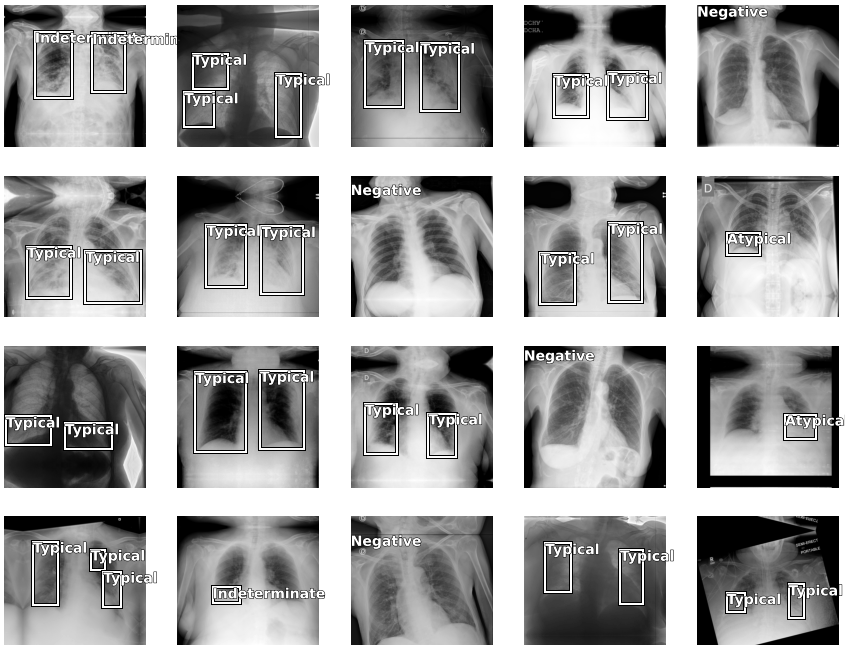

This notebook goes through the intial setup and pipeline details.

- Load dependancies - ..done
- DataFrame creation - ..done
- Analysis - ..in progress
- DataBlock - ..done
- Model - ..RetinaNet(with mAP)
- Training - ..in progress
- Submission - ..to do

### Load Dependancies

Noted that this is a kernels competition and during submission internet will not be allowed.  However for initial prototyping I have not taken that into consideration.

GDCM will be required to prevent error messages

In [ ]:
!pip install python-gdcm -q

[fmi](https://github.com/asvcode/fmi) is a package that adds additional functionality to fastai's medical imaging module

In [ ]:
!git clone https://github.com/asvcode/fmi.git

In [ ]:
from fmi.fmi.explore import *
from fmi.fmi.preprocessing import *
from fmi.fmi.pipeline import *
from fmi.fmi.retinanet import *

Load the other dependancies

In [ ]:
from fastai.vision.all import *
from fastai.medical.imaging import *
import pydicom
import cv2
from pydicom.pixel_data_handlers.util import apply_voi_lut
import gdcm
from torchvision.utils import save_image

You can easily review your system info using `system_info`

In [ ]:
system_info()

Load the data

In [ ]:
source = '../input/siim-covid19-detection'
print(os.listdir(source))

train_images = get_dicom_files(f'{source}/train')
test_images = get_dicom_files(f'{source}/test')

dicom_dataframe = pd.read_csv('../input/fmipackage/dicom_dataframe.csv')
test_dataframe = pd.read_csv('../input/fmipackage/test_dataframe.csv')

Note that I had previously created `dicom_dataframe` and `test_dataframe` to extract all the metadata from the dicom images using `dicom_dataframe = pd.DataFrame.from_dicoms(train_images, px_summ = True, window=dicom_windows.lungs)`.  Set px_summ to `True` if you want additional image statistics but bare in mind that this will slow down the process

### More about DICOMS

- For more information about DICOMS view [this](https://www.kaggle.com/avirdee/understanding-dicoms) notebook and/or [this](https://asvcode.github.io/MedicalImaging/) blog

Each DICOM contains metadata and this is typically how you see it(usually alot of info)

In [ ]:
dcm =  train_images[0]
dcm.dcmread()

[fmi](https://github.com/asvcode/fmi) has a number of handy features that breakdown the metadata into useful chunks. Firstly you may want to quickly see what image information is contained in the metadata.  You can access this using `get_image_info`

In [ ]:
get_image_info(train_images[7])

Note that this dataset contains multiple modalities and photometric interpretations but what `get_image_info` does do is tell you what attributes are contained within the metadata.

An important factor when dealing with medical data is to check to see if there are any personally identifiable pieces of information within the metadata.  This potentially can have an effect on the final outcome of the model, for example if the training set only contained images of male patients and the test set had images of both male and female patients.  Understanding what identifiable information is contained within the metadata is important in creating a fair non-biased model.

using `get_pii` quickly accesses this information. 

In [ ]:
get_pii(train_images[7])

There are a couple of things `get_pii` looks for like image comments, sometimes this can contain information that is handy.  Not all DICOMs will mention the de-identification method but if it is included it is handy to review.  More information about DICOM attributes can be found [here](https://dicom.innolitics.com/ciods/segmentation/general-image/00080008)

### DataFrame Creation

Load the train_image_level and train_study_level `csv` files

In [ ]:
train_image_level = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')
train_study_level = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')

On train_study_level we will rename the `id` column to `StudyInstanceUID` so that we can then merge it with the train_image_level file.

In [ ]:
train_study_level.rename(columns = {'id':'StudyInstanceUID'}, inplace = True)
train_study_level[:1]

We then get rid of the `_study` in `StudyInstanceUID`

In [ ]:
train_study_level['StudyInstanceUID'] = train_study_level['StudyInstanceUID'].apply(lambda x: f'{x[:12]}')
train_study_level[:1]

We can now merge the train_image_level and train_study_level files

In [ ]:
merged = pd.merge(train_image_level, train_study_level, on='StudyInstanceUID')
merged[:1]

And then we do some clean up! We create a single column that contains the class and get rid of a number of columns.  Note we also get rid of the `boxes` column as we will be using the `label` column for generating the binding boxes.

In [ ]:
merged['id'] = merged['id'].apply(lambda x: f'{x[:-6]}')
merged.loc[merged['Negative for Pneumonia']==1, 'class_y'] = 'Negative'
merged.loc[merged['Typical Appearance']==1, 'class_y'] = 'Typical'
merged.loc[merged['Indeterminate Appearance']==1, 'class_y'] = 'Indeterminate'
merged.loc[merged['Atypical Appearance']==1, 'class_y'] = 'Atypical'
merged.drop(['boxes', 'Negative for Pneumonia', 'Typical Appearance', 
             'Indeterminate Appearance', 'Atypical Appearance', 'StudyInstanceUID'], axis=1, inplace=True)
merged[:1]

We now extract out the binding box co-ordinates but first we check to see how many boxes are present for each image

In [ ]:
num_of_boxes = []
for i in merged.index:
    val_len = len(merged['label'][i].split(' '))
    val = merged['label'][i].split(' ')
    label = merged['class_y'][i]
    box_count = val_len//6
    num_of_boxes.append(box_count)

In [ ]:
merged['num_of_boxes'] = num_of_boxes
merged[:5]

In [ ]:
merged['num_of_boxes'].value_counts()

Now we extract the box co-ordinates

In [ ]:
m = []
for i in merged.index:
    num_of_boxes = merged['num_of_boxes'][i]
    val = merged['label'][i].split(' ')
    if num_of_boxes == 1: boxes = val[2:6]
    if num_of_boxes == 2: boxes = val[2:6] + val[8:12]
    if num_of_boxes == 3: boxes = val[2:6] + val[8:12] + val[14:18]
    if num_of_boxes == 4: boxes = val[2:6] + val[8:12] + val[14:18] + val[20:24]
    m.append(boxes)

In [ ]:
merged['new_label'] = m
del merged['label']
merged[:2]

We can now merge this to the dicom_dataframe created earlier.  In order to do this we need to rename `id` to `SOPInstanceUID` and merge on `SOPInstanceUID`

In [ ]:
merged.rename(columns = {'id':'SOPInstanceUID'}, inplace = True)
merged[:1]

In [ ]:
dicom_merge = pd.merge(dicom_dataframe, merged, on='SOPInstanceUID')
dicom_merge[:1]

#### Sanity Check

Checking to see that the file path `fname` corresponds to the correct `SOPINstanceUID`

In [ ]:
dicom_merge['fname'][100]

In [ ]:
dicom_merge["SOPInstanceUID"][100]

In [ ]:
dicom_merge.to_csv('dicom_merge.csv', index=False)

### Analysis

This dataset contains a wide variety of pixel data characteristics and we can explore this using the merged dataframe earlier.

**ORIGINAL :**  an image whose pixel values are based on original or source data

**DERIVED :**  an image whose pixel values have been derived in some manner from the pixel value of one or more other images

**PRIMARY :** an image created as a direct result of the patient examination

**SECONDARY :** an image created after the initial patient examination

In [ ]:
analysis_flds = ['ImageType', 'ImageType1', 'BitsStored']
dicom_merge.pivot_table(values=['img_mean','img_max','img_min', 'PatientID'], index=analysis_flds,
                   aggfunc={'img_mean':'mean','img_max':'max','img_min':'min', 'PatientID':'count'})

From the pivot table above we can see that the data is unsigned ie have a minimum pixel value of 0 but have a variety of max values ranging from 255 (8 bit), 1023 (10 bit), 4095 (12 bit), 16383 (14 bit), 32415 (15 bit) and 65535 (16 bit).  The majority of the images are 12 bit.

What about if we break it down further by class:

In [ ]:
analysis_flds = ['ImageType', 'ImageType1', 'class_y', 'BitsStored']
dicom_merge.pivot_table(values=['img_mean','img_max','img_min', 'PatientID'], index=analysis_flds,
                   aggfunc={'img_mean':'mean','img_max':'max','img_min':'min', 'PatientID':'count'})

The good thing about this is that most medical datasets are biased because they only typically have data from 1 institution but in this case it looks like the data may be from a number of institutions which should help with better generalization.

**Test Set Breakdown**

Looking at the `BitsStored` distribution in the test set

In [ ]:
analysis_flds = ['ImageType', 'ImageType1', 'BitsStored']
test_dataframe.pivot_table(values=['img_mean','img_max','img_min', 'PatientID'], index=analysis_flds,
                   aggfunc={'img_mean':'mean','img_max':'max','img_min':'min', 'PatientID':'count'})

### DataBlock

To make it easier we create a new dataframe from the previous created dataframe using only the columns that are important for using in the DataBlock

In [ ]:
df = dicom_merge[['SOPInstanceUID', 'class_y', 'new_label', 'fname']].copy()
df[:5]

Create a function to easily view images and bounding boxes

In [ ]:
def ViewBBImage(df):
    fp = pydicom.dcmread(Path(df['fname'].item())).pixel_array
    title = df['class_y'].item()
    boxes = np.array(df['new_label'])
    box_len = len(boxes[0])
    if box_len ==16:
        bb = np.array(boxes[0][:4] + boxes[0][4:8] + boxes[0][8:12] + boxes[0][12:16]).astype(np.float16) 
    if box_len ==12:
        bb = np.array(boxes[0][:4] + boxes[0][4:8] + boxes[0][8:12]).astype(np.float16)
    if box_len ==8:
        bb = np.array(boxes[0][:4] + boxes[0][4:8]).astype(np.float16)
    if box_len ==4:
        bb = np.array(boxes[0][:4]).astype(np.float16)
    
    box1 = TensorBBox([bb])
    ctx = show_image(fp, title=title)
    box1.show(ctx=ctx)

In [ ]:
df[10:20]

In [ ]:
ViewBBImage(df[19:20])

In [ ]:
ViewBBImage(df[17:18])

The differences above in the image quality is because the first one has a `PhotochromicInterpretation` of `MONOCHROME1`and the second one is `MONOCHROME2`.  This is fixed further below.

The following below was inspired by this fantastic [notebook](https://www.kaggle.com/muellerzr/fastai2-starter-kernel)

In [ ]:
im_df = df['fname'].unique()
im_df = [fn for fn in im_df]
fns = [Path(str(f'{fn}')) for fn in im_df]
fns[:5]

In [ ]:
def get_items(noop): return fns

Convert the dataframe into a numpy array to improve processing times

In [ ]:
df_np = df.to_numpy()
df_np[0]

For a sanity check, check to see that the class label and binding boxes are accessible from the array

In [ ]:
df_np[0][1]

In [ ]:
df_np[0][-2]

In [ ]:
def get_tmp_bbox(fn):
    rows = np.where(df_np[:,0] == fn.name[:-4])
    bboxs = df_np[rows][:,-2][0]
    return np.array([np.fromstring(b, sep=',') for b in bboxs])

In [ ]:
get_tmp_bbox(get_items(source)[1])

Each image may have multiple boxes so in order for this to work in `fastai` we need to ensure that each box has a label

In [ ]:
def get_tmp_lbl(fn):
    rows = np.where((df_np[:, 0] == fn.name[:-4]))
    bboxs = len(df_np[rows][:,-2][0])
    if bboxs > 12:
        return np.concatenate(([df_np[rows][:,1]]*4))
    if bboxs > 8:
        return np.concatenate(([df_np[rows][:,1]]*3))
    if bboxs > 4:
        return np.concatenate(([df_np[rows][:,1]]*2))
    else:
        return df_np[rows][:,1]

Sanity check, if there are 12 co-ordinates there should be 4 labels

In [ ]:
get_tmp_lbl(get_items(source)[920])

And if there are only 4 co-ordinates there should only be 1 label

In [ ]:
get_tmp_lbl(get_items(source)[0])

In [ ]:
bboxs = get_tmp_bbox(fns[0])
lbls = get_tmp_lbl(fns[0])
arr = np.array([fns[0].name[:-4], bboxs, lbls], dtype=object)

In [ ]:
arr

Do the same for the whole dataset

In [ ]:
for fname in fns[1:]:
    bbox = get_tmp_bbox(fname)
    lbl = get_tmp_lbl(fname)
    arr2 = np.array([fname.name[:-4], bbox, lbl], dtype='object')
    arr = np.vstack((arr, arr2))

Check to see the `get_bbox` function returns the box co-ordinates

In [ ]:
def get_bbox(fn):
    idx = np.where((arr[:,0] == fn.name[:-4]))
    return arr[idx][0][1]

In [ ]:
get_bbox(get_items(source)[1])

Check the same for the label

In [ ]:
def get_lbl(fn):
    idx = np.where((arr[:,0] == fn.name[:-4]))
    return arr[idx][0][-1]

In [ ]:
get_lbl(get_items(source)[1])

Create the `DataBlock`

Out of the box using `ImageBlock(cls=PILDicom)` will throw a ValueError: image has wrong mode. [fmi](https://github.com/asvcode/fmi) however has a couple of options that prevents this error from occuring.

**DicomView**

In [ ]:
set_seed(77)
siim = DataBlock(blocks=(ImageBlock(cls=DicomView), BBoxBlock, BBoxLblBlock),
                 get_items=get_items,
                 splitter=RandomSplitter(),
                 get_y=[get_bbox, get_lbl],
                 item_tfms=Resize(512, method=ResizeMethod.Pad),
                 n_inp=1)

dls = siim.dataloaders(f'{source}/train', bs=64)
dls.show_batch(max_n=20, ncols=5)

Although this works, you can clearly see the differences between images that have `PhotometricInterpretation` of `MONOCHROME1` and `MONOCHROME2`.  This is compenstated for further below.

**HistView**

As mentioned in this [notebook](https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai) do computers really need to worry about how many levels of grayscale are displayed on the screen?  Converting 16 bit or 12 bit images to 8 bit are purely done for human reasons. 

Computers prefer well scaled inputs.  A neural network uses 32 bit floating point inputs that provides a high level of precision, particulary for numbers close to zero. `HistView` is a way of viewing dicom images that have been scaled to values between 0 and 1.

In [ ]:
set_seed(77)
siim = DataBlock(blocks=(ImageBlock(cls=HistView), BBoxBlock, BBoxLblBlock),
                 get_items=get_items,
                 splitter=RandomSplitter(),
                 get_y=[get_bbox, get_lbl],
                 item_tfms=Resize(512, method=ResizeMethod.Pad),
                 n_inp=1)

dls = siim.dataloaders(f'{source}/train', bs=64)
dls.show_batch(max_n=20, ncols=5)

We still suffer from the variations in monochrome(which we fix next) but the images specifically in the lungs area look alot better.  We create a new class `FixMonochrome` that inherits from `PILDicom` and here we can fix the monochrome issue. (you can also use `hist_scaled` when accessing the pixel_array, this however does really increase the training time)

In [ ]:
class FixMonochrome(PILDicom):
    @classmethod
    def create(cls, fn:(Path, str, bytes), fix_monochrome = True)->None:
        if isinstance(fn, bytes): im = pydicom.dcmread(pydicom.filebase.DicomBytesIO(fn))
        if isinstance(fn, (Path, str)): im = pydicom.dcmread(fn)
        scaled = np.array(im.pixel_array)   
        if fix_monochrome and im.PhotometricInterpretation == "MONOCHROME1":
            scaled = np.amax(scaled) - scaled
        scaled = scaled - np.min(scaled)
        scaled = scaled / np.max(scaled)
        scaled = (scaled * 255).astype(np.uint8)
        pill_im = Image.fromarray(scaled)
        return cls(pill_im)

In [ ]:
set_seed(77)
siim = DataBlock(blocks=(ImageBlock(cls=FixMonochrome), BBoxBlock, BBoxLblBlock),
                 get_items=get_items,
                 splitter=RandomSplitter(),
                 get_y=[get_bbox, get_lbl],
                 item_tfms=Resize(32, method=ResizeMethod.Pad),
                 n_inp=1)

dls = siim.dataloaders(f'{source}/train', bs=128)
dls.show_batch(max_n=20, ncols=5)

To check the shapes of the batches we can use `one_batch`

In [ ]:
img, bbox, lbl = dls.one_batch()

Each batch has 128 images (due to the batch size of 128)

In [ ]:
img.shape

We can also view the batch images like so:

In [ ]:
show_images(img, nrows=4)

Each batch also has 128 sets of `TensorBBox`'s

In [ ]:
bbox.shape

In [ ]:
bbox[0]

As well as 128 sets of y_labels

In [ ]:
lbl.shape

In [ ]:
lbl[0]

### Model

The model used is RetinaNet which is based on the [Focal Loss for Dense Object Detection](https://arxiv.org/pdf/1708.02002.pdf) paper.  The code is originally from [this](https://github.com/fastai/course-v3/blob/master/nbs/dl2/pascal.ipynb) notebook and integrated into the [fmi](https://github.com/asvcode/fmi) library

**RetinaNet**


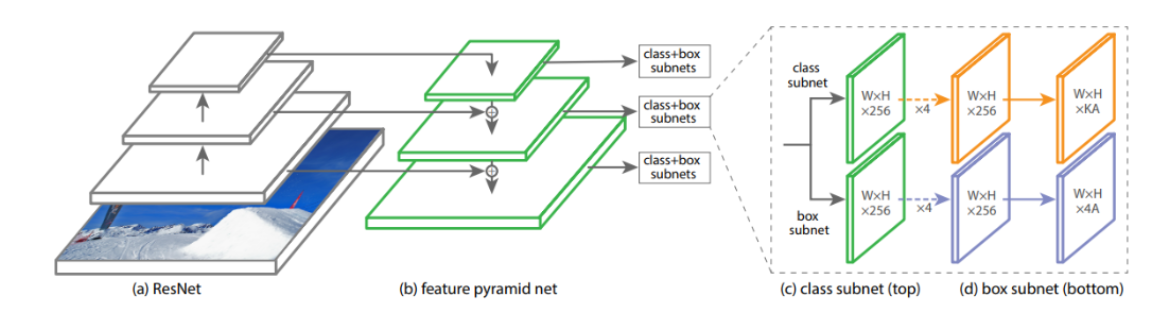
[Image Credit](https://developers.arcgis.com/python/guide/how-retinanet-works/)



There are 4 major components:

**1) Bottom-up Pathway** - The backbone network in this example `Resnet34`

If image size is (256, 256) and the backbone is a resnet then there would be the following feature maps:

- input (256, 256)
- C1 (128, 128)
- C2 (64, 64)
- C3 (32, 32)
- C4 (16, 16)
- C5 (8, 8)
- The paper states that two additional features maps at C6 and C7 of sizes (4,4) and (2,2) by using stride-2 convolutions are also added

**2) Top-down pathway and Lateral connections** - The top down pathway upsamples the spatially coarser feature maps from higher pyramid levels, and the lateral connections merge the top-down layers and the bottom-up layers with the same spatial size.

- C7 moves to P7 (2, 2)
- P6 (4, 4)
- P5 (8, 8)
- P4 (16, 16)
- P3 (32, 32)
- P2 (64, 64)

The P7 feature map is used in detecting larger objects whilst P2 would be used to detect smaller objects

**3) Classification subnetwork** - Predicts the probability of an object being present at each spatial location for each anchor box and object class.

**4) Regression subnetwork** - Regresses the offset for the bounding boxes from the anchor boxes for each ground-truth object.

To view the number of classes

In [ ]:
num_of_classes = len(dls.vocab[1:])
num_of_classes

Create the model

We use `Resnet34` as the backbone network, however we need to make a slight modification so that the body can accept 1D images.

In [ ]:
encoder = create_body(resnet34, pretrained=True)

l = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2),
                    padding=(3,3), bias=False)
l.weight = nn.Parameter(l.weight.sum(dim=1, keepdim=True))

encoder[0] = l

In [ ]:
arch = RetinaNet(encoder, num_of_classes, final_bias=-4)

The paper states that the **Focal Loss** is designed to address the one-stage object detection scenario in which there is an extreme imbalance between foreground and background classes during training.  Focal Loss is an enhancemnet over Cross-Entropy Loss.  

One-stage models can suffer from extreme foreground-background class imbalance problems due to dense sampling of possible object locations (anchor boxes).  In RetinaNet, at each pyramid layer there can be thousands of achor boxes and only a few will be assigned to the ground-truth object whilst the vast majority (easy examples) will be assigned to the background class.

Focal Loss reduces the loss contribution from the easy examples and hence increase the importance of correcting missclassified examples.

**Parameters**

**Scales of anchor boxes** The default is set to [2^0, 2^⅓, 2^⅔ ] which is what the paper uses.


**Aspect Ratios of anchor boxes** The default is set to [0.5, 1, 2] which means the anchor boxes will be of aspect ratios 1:2, 1:1, 2:1.

In [ ]:
aspect_ratios = [0.5, 1, 2]
scales = [2**0, 2**(1/3), 2**(2/3)]

In [ ]:
crit = RetinaNetFocalLoss(arch, scales=scales, ratios=aspect_ratios)

The code for the mAP is credited to [this](https://github.com/fastai/course-v3/blob/master/nbs/dl2/pascal.ipynb](https://github.com/fastai/course-v3/blob/master/nbs/dl2/pascal.ipynb) and [this](https://github.com/jaidmin/Practical-Deep-Learning-for-Coders-2.0](https://github.com/jaidmin/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/06_Object_Detection_changed.ipynb) notebook.

The general definition for **Average Precision(AP)** is finding the area under the Precision-Recall curve. Precision-Recall curves are generally used when there is a moderate to large class imbalance, as opposed to ROC curves which are used when there are roughly equal numbers of observations for each class.

To calculate the AP for object detection we need to understand **Intersection of Union(IoU)** which is the ratio of the area of intersection and the area of union (union between predicted bounding box and ground truth bounding box).

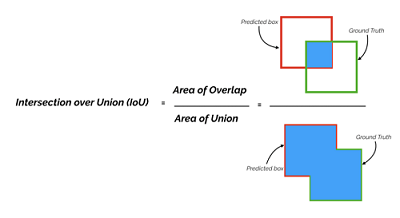

**mAP(mean average precision)** is the average of AP.

The mean Average Precision or mAP score is calculated by taking the mean AP over all classes and/or overall IoU thresholds, depending on different detection challenges that exist.

For example in the PASCAL VOC2007 challenge, AP for one object class is calculated for an IoU threshold of 0.5. So the mAP is averaged over all object classes and for the COCO 2017 challenge, the mAP is averaged over all object categories and 10 IoU thresholds.

In [ ]:
map_metric = mAP()
metrics = [map_metric]

In [ ]:
learn = Learner(dls, 
                arch, 
                loss_func=crit, 
                metrics=metrics, 
                cbs=[ShowGraphCallback()])

### Training

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1,1e-4)

In [ ]:
learn.save('siim_one')

In [ ]:
learn.cbs[3].threshold = 0.7

In [ ]:
learn.show_results()

### More to come!